In [ ]:
! unzip archive.zip

Archive:  archive.zip
replace BankChurners.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: н
error:  invalid response [н]
replace BankChurners.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: BankChurners.csv        


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
from sklearn import metrics
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score,roc_auc_score, roc_curve, confusion_matrix
from sklearn.model_selection import train_test_split ,GridSearchCV, RandomizedSearchCV,StratifiedKFold, cross_val_score
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (
    AdaBoostClassifier,
    GradientBoostingClassifier,
    RandomForestClassifier,BaggingClassifier)
from xgboost import XGBClassifier

In [ ]:
df = pd.read_csv('/content/BankChurners.csv')
df.head()

,CLIENTNUM,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio,Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1,Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2
0,768805383,Existing Customer,45,M,3,High School,Married,$60K - $80K,Blue,39,5,1,3,12691.0,777,11914.0,1.335,1144,42,1.625,0.061,0.000093,0.99991
1,818770008,Existing Customer,49,F,5,Graduate,Single,Less than $40K,Blue,44,6,1,2,8256.0,864,7392.0,1.541,1291,33,3.714,0.105,0.000057,0.99994
2,713982108,Existing Customer,51,M,3,Graduate,Married,$80K - $120K,Blue,36,4,1,0,3418.0,0,3418.0,2.594,1887,20,2.333,0.000,0.000021,0.99998
3,769911858,Existing Customer,40,F,4,High School,Unknown,Less than $40K,Blue,34,3,4,1,3313.0,2517,796.0,1.405,1171,20,2.333,0.760,0.000134,0.99987
4,709106358,Existing Customer,40,M,3,Uneducated,Married,$60K - $80K,Blue,21,5,1,0,4716.0,0,4716.0,2.175,816,28,2.500,0.000,0.000022,0.99998


In [ ]:
# дубликатов нет
df.duplicated().sum()

0

В 4 строке в стоблце Marital_Status присутствует Unknown, это нужно будет учесть

Удаляю столбец CLIENTNUM, поскольку он уникален для каждого клиента и бесполезен для модели, а так же удаляю 2 последних стоблца, потому что они бесполезны.

In [ ]:
df = df.drop(labels=['CLIENTNUM',
                     'Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1',
                     'Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2'],
                     axis=1)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10127 entries, 0 to 10126
Data columns (total 20 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Attrition_Flag            10127 non-null  object 
 1   Customer_Age              10127 non-null  int64  
 2   Gender                    10127 non-null  object 
 3   Dependent_count           10127 non-null  int64  
 4   Education_Level           10127 non-null  object 
 5   Marital_Status            10127 non-null  object 
 6   Income_Category           10127 non-null  object 
 7   Card_Category             10127 non-null  object 
 8   Months_on_book            10127 non-null  int64  
 9   Total_Relationship_Count  10127 non-null  int64  
 10  Months_Inactive_12_mon    10127 non-null  int64  
 11  Contacts_Count_12_mon     10127 non-null  int64  
 12  Credit_Limit              10127 non-null  float64
 13  Total_Revolving_Bal       10127 non-null  int64  
 14  Avg_Op

In [ ]:
# есть ли пустые значения
df.isna().sum()

Attrition_Flag              0
Customer_Age                0
Gender                      0
Dependent_count             0
Education_Level             0
Marital_Status              0
Income_Category             0
Card_Category               0
Months_on_book              0
Total_Relationship_Count    0
Months_Inactive_12_mon      0
Contacts_Count_12_mon       0
Credit_Limit                0
Total_Revolving_Bal         0
Avg_Open_To_Buy             0
Total_Amt_Chng_Q4_Q1        0
Total_Trans_Amt             0
Total_Trans_Ct              0
Total_Ct_Chng_Q4_Q1         0
Avg_Utilization_Ratio       0
dtype: int64

In [ ]:
df.describe()

,Customer_Age,Dependent_count,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio
count,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000
mean,46.325960,2.346203,35.928409,3.812580,2.341167,2.455317,8631.953698,1162.814061,7469.139637,0.759941,4404.086304,64.858695,0.712222,0.274894
std,8.016814,1.298908,7.986416,1.554408,1.010622,1.106225,9088.776650,814.987335,9090.685324,0.219207,3397.129254,23.472570,0.238086,0.275691
min,26.000000,0.000000,13.000000,1.000000,0.000000,0.000000,1438.300000,0.000000,3.000000,0.000000,510.000000,10.000000,0.000000,0.000000
25%,41.000000,1.000000,31.000000,3.000000,2.000000,2.000000,2555.000000,359.000000,1324.500000,0.631000,2155.500000,45.000000,0.582000,0.023000
50%,46.000000,2.000000,36.000000,4.000000,2.000000,2.000000,4549.000000,1276.000000,3474.000000,0.736000,3899.000000,67.000000,0.702000,0.176000
75%,52.000000,3.000000,40.000000,5.000000,3.000000,3.000000,11067.500000,1784.000000,9859.000000,0.859000,4741.000000,81.000000,0.818000,0.503000
max,73.000000,5.000000,56.000000,6.000000,6.000000,6.000000,34516.000000,2517.000000,34516.000000,3.397000,18484.000000,139.000000,3.714000,0.999000


Баланс классов

In [ ]:
df['Attrition_Flag'].value_counts()

Existing Customer    8500
Attrited Customer    1627
Name: Attrition_Flag, dtype: int64

In [ ]:
# название колонок
df.columns

Index(['Attrition_Flag', 'Customer_Age', 'Gender', 'Dependent_count',
       'Education_Level', 'Marital_Status', 'Income_Category', 'Card_Category',
       'Months_on_book', 'Total_Relationship_Count', 'Months_Inactive_12_mon',
       'Contacts_Count_12_mon', 'Credit_Limit', 'Total_Revolving_Bal',
       'Avg_Open_To_Buy', 'Total_Amt_Chng_Q4_Q1', 'Total_Trans_Amt',
       'Total_Trans_Ct', 'Total_Ct_Chng_Q4_Q1', 'Avg_Utilization_Ratio'],
      dtype='object')

Вернемся к неизвестным в колонках


In [ ]:
df.apply(lambda x: sum(x=='Unknown') / len(df))

Attrition_Flag              0.000000
Customer_Age                0.000000
Gender                      0.000000
Dependent_count             0.000000
Education_Level             0.149995
Marital_Status              0.073961
Income_Category             0.109805
Card_Category               0.000000
Months_on_book              0.000000
Total_Relationship_Count    0.000000
Months_Inactive_12_mon      0.000000
Contacts_Count_12_mon       0.000000
Credit_Limit                0.000000
Total_Revolving_Bal         0.000000
Avg_Open_To_Buy             0.000000
Total_Amt_Chng_Q4_Q1        0.000000
Total_Trans_Amt             0.000000
Total_Trans_Ct              0.000000
Total_Ct_Chng_Q4_Q1         0.000000
Avg_Utilization_Ratio       0.000000
dtype: float64

Education_Level-14 %
Marital_Status-7%
Income_Category-10%

Удалим, чтобы не мешал

In [ ]:
df = df[~df['Education_Level'].str.contains('Unknown')] 
df = df[~df['Marital_Status'].str.contains('Unknown')]
df = df[~df['Income_Category'].str.contains('Unknown')]

In [ ]:
df.dtypes

Attrition_Flag               object
Customer_Age                  int64
Gender                       object
Dependent_count               int64
Education_Level              object
Marital_Status               object
Income_Category              object
Card_Category                object
Months_on_book                int64
Total_Relationship_Count      int64
Months_Inactive_12_mon        int64
Contacts_Count_12_mon         int64
Credit_Limit                float64
Total_Revolving_Bal           int64
Avg_Open_To_Buy             float64
Total_Amt_Chng_Q4_Q1        float64
Total_Trans_Amt               int64
Total_Trans_Ct                int64
Total_Ct_Chng_Q4_Q1         float64
Avg_Utilization_Ratio       float64
dtype: object

Разделение колонок

In [ ]:
s = (df.dtypes == 'object')
cat_cols = list(s[s].index)

s = (df.dtypes == 'float64')
float_cols = list(s[s].index)

s = (df.dtypes == 'int64')
int_cols = list(s[s].index)

print(f'categorial cols: {cat_cols}')
print(f'float cols: {float_cols}')
print(f'int cols: {int_cols}')

categorial cols: ['Attrition_Flag', 'Gender', 'Education_Level', 'Marital_Status', 'Income_Category', 'Card_Category']
float cols: ['Credit_Limit', 'Avg_Open_To_Buy', 'Total_Amt_Chng_Q4_Q1', 'Total_Ct_Chng_Q4_Q1', 'Avg_Utilization_Ratio']
int cols: ['Customer_Age', 'Dependent_count', 'Months_on_book', 'Total_Relationship_Count', 'Months_Inactive_12_mon', 'Contacts_Count_12_mon', 'Total_Revolving_Bal', 'Total_Trans_Amt', 'Total_Trans_Ct']


Значения для численных колонок колонок

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7ff909439910>,
      dtype=object)

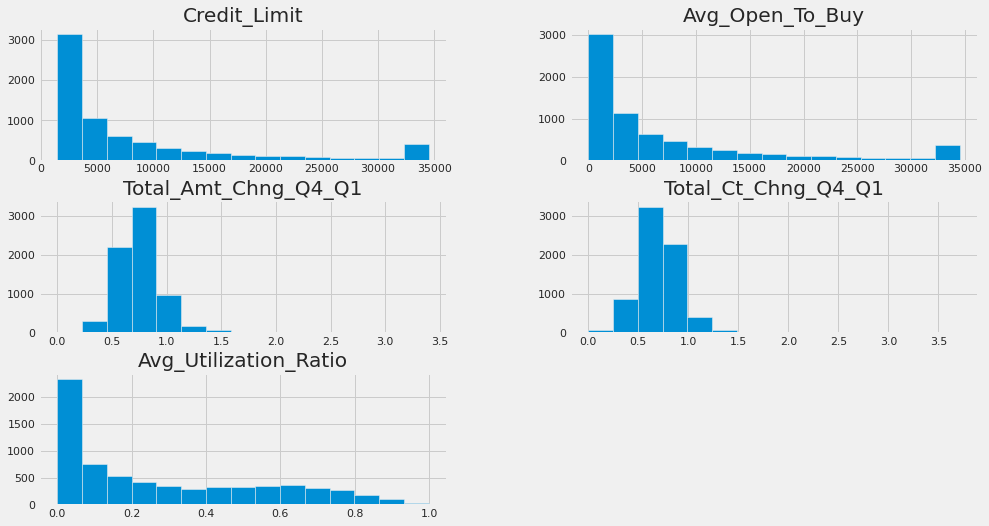

In [ ]:
df[float_cols].hist(bins=15, figsize=(15, 20), layout=(7,2))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7ff908256fd0>,
      dtype=object)

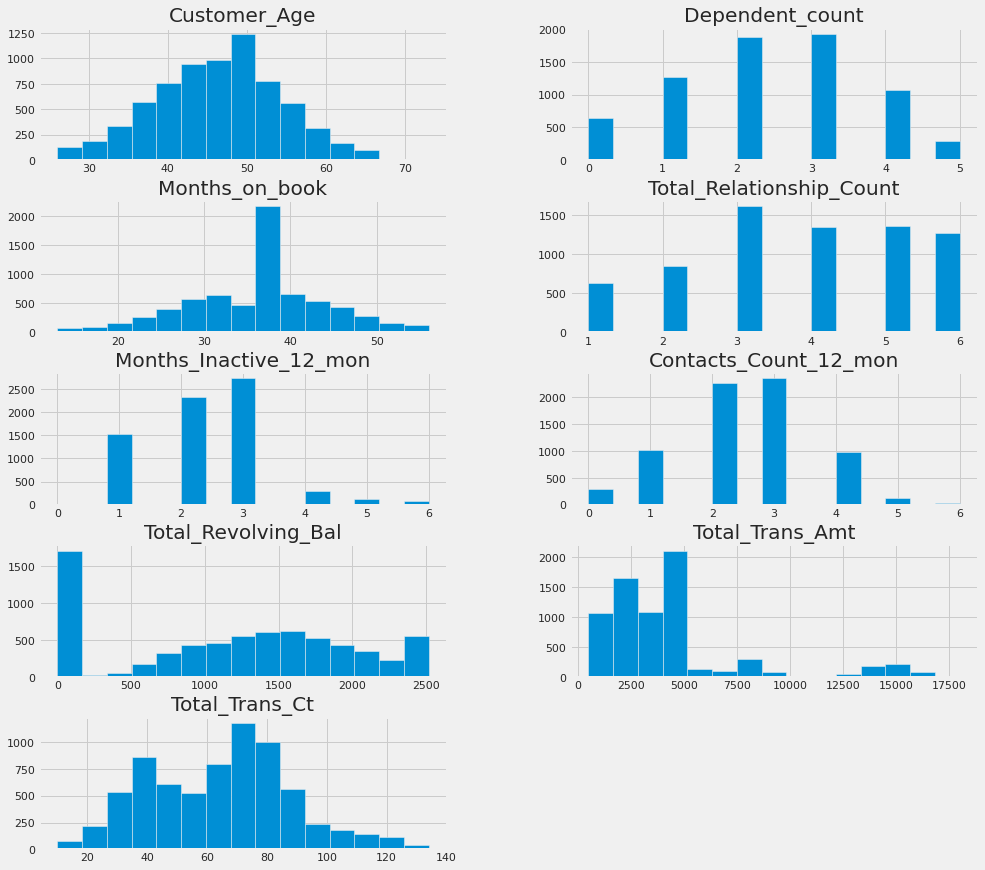

In [ ]:
df[int_cols].hist(bins=15, figsize=(15, 20), layout=(7,2))

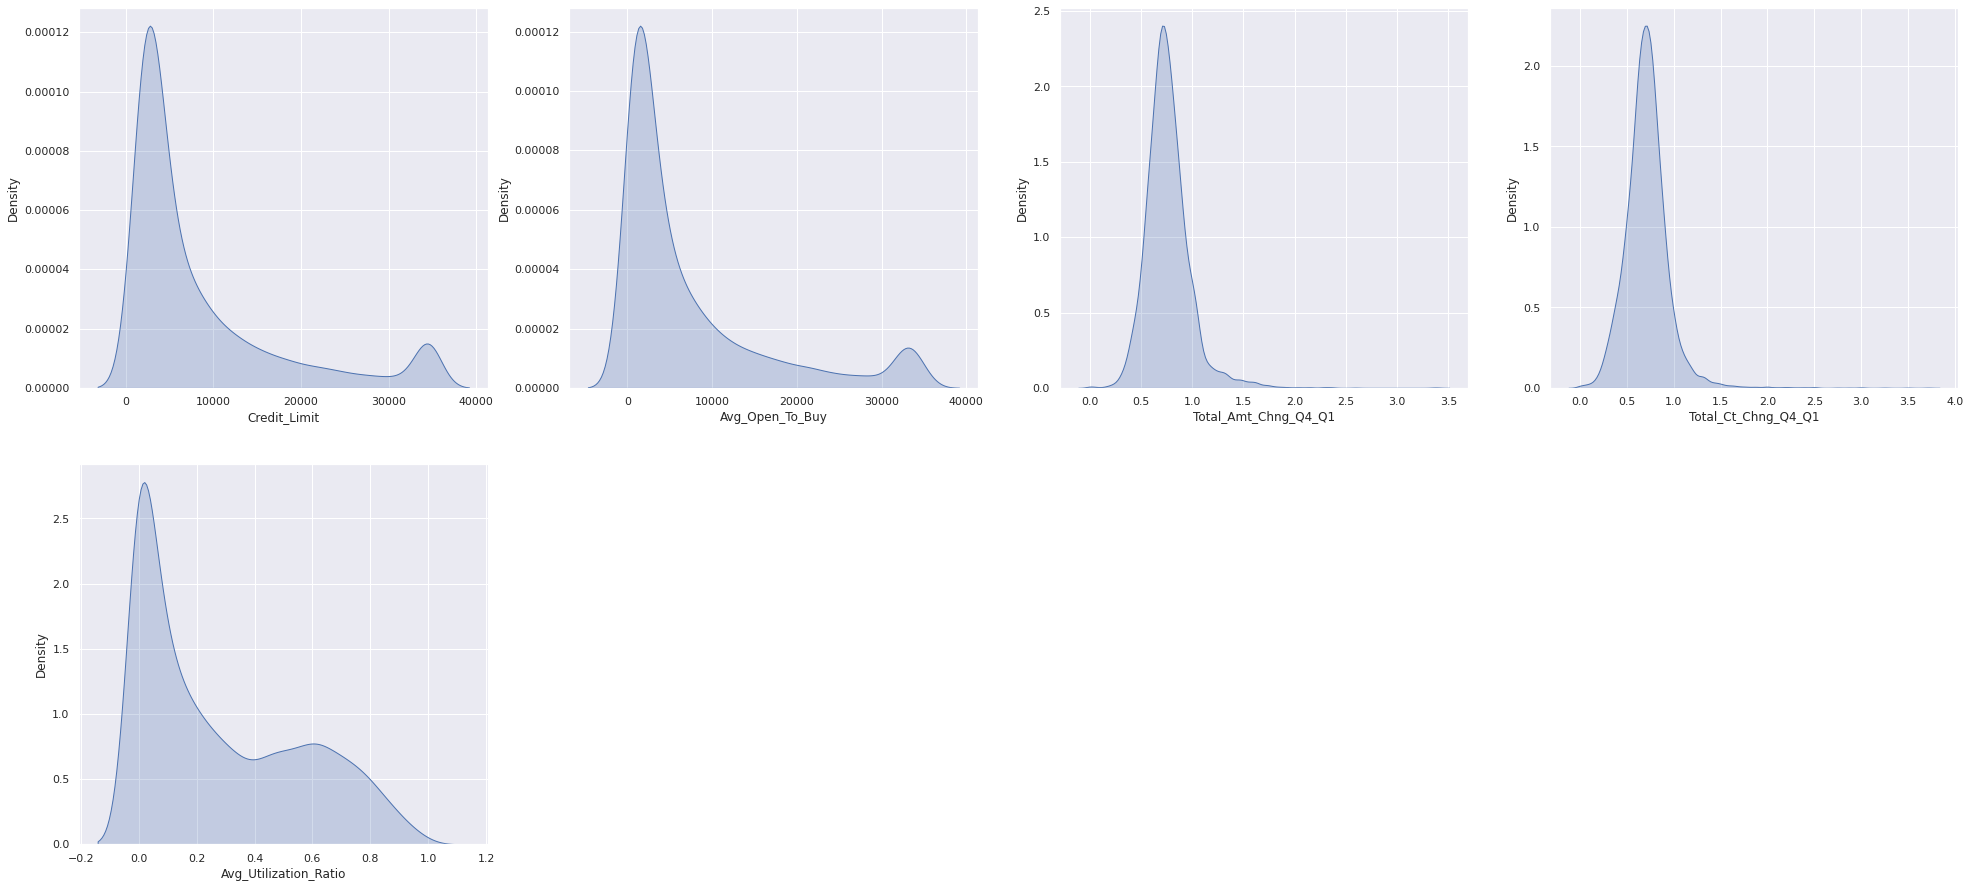

In [ ]:
sns.set(rc={'figure.figsize': (30, 30)})
for i in range(len(float_cols)):
    plt.subplot(4, 4, i + 1)
    sns.kdeplot(df[float_cols[i]], shade=True)

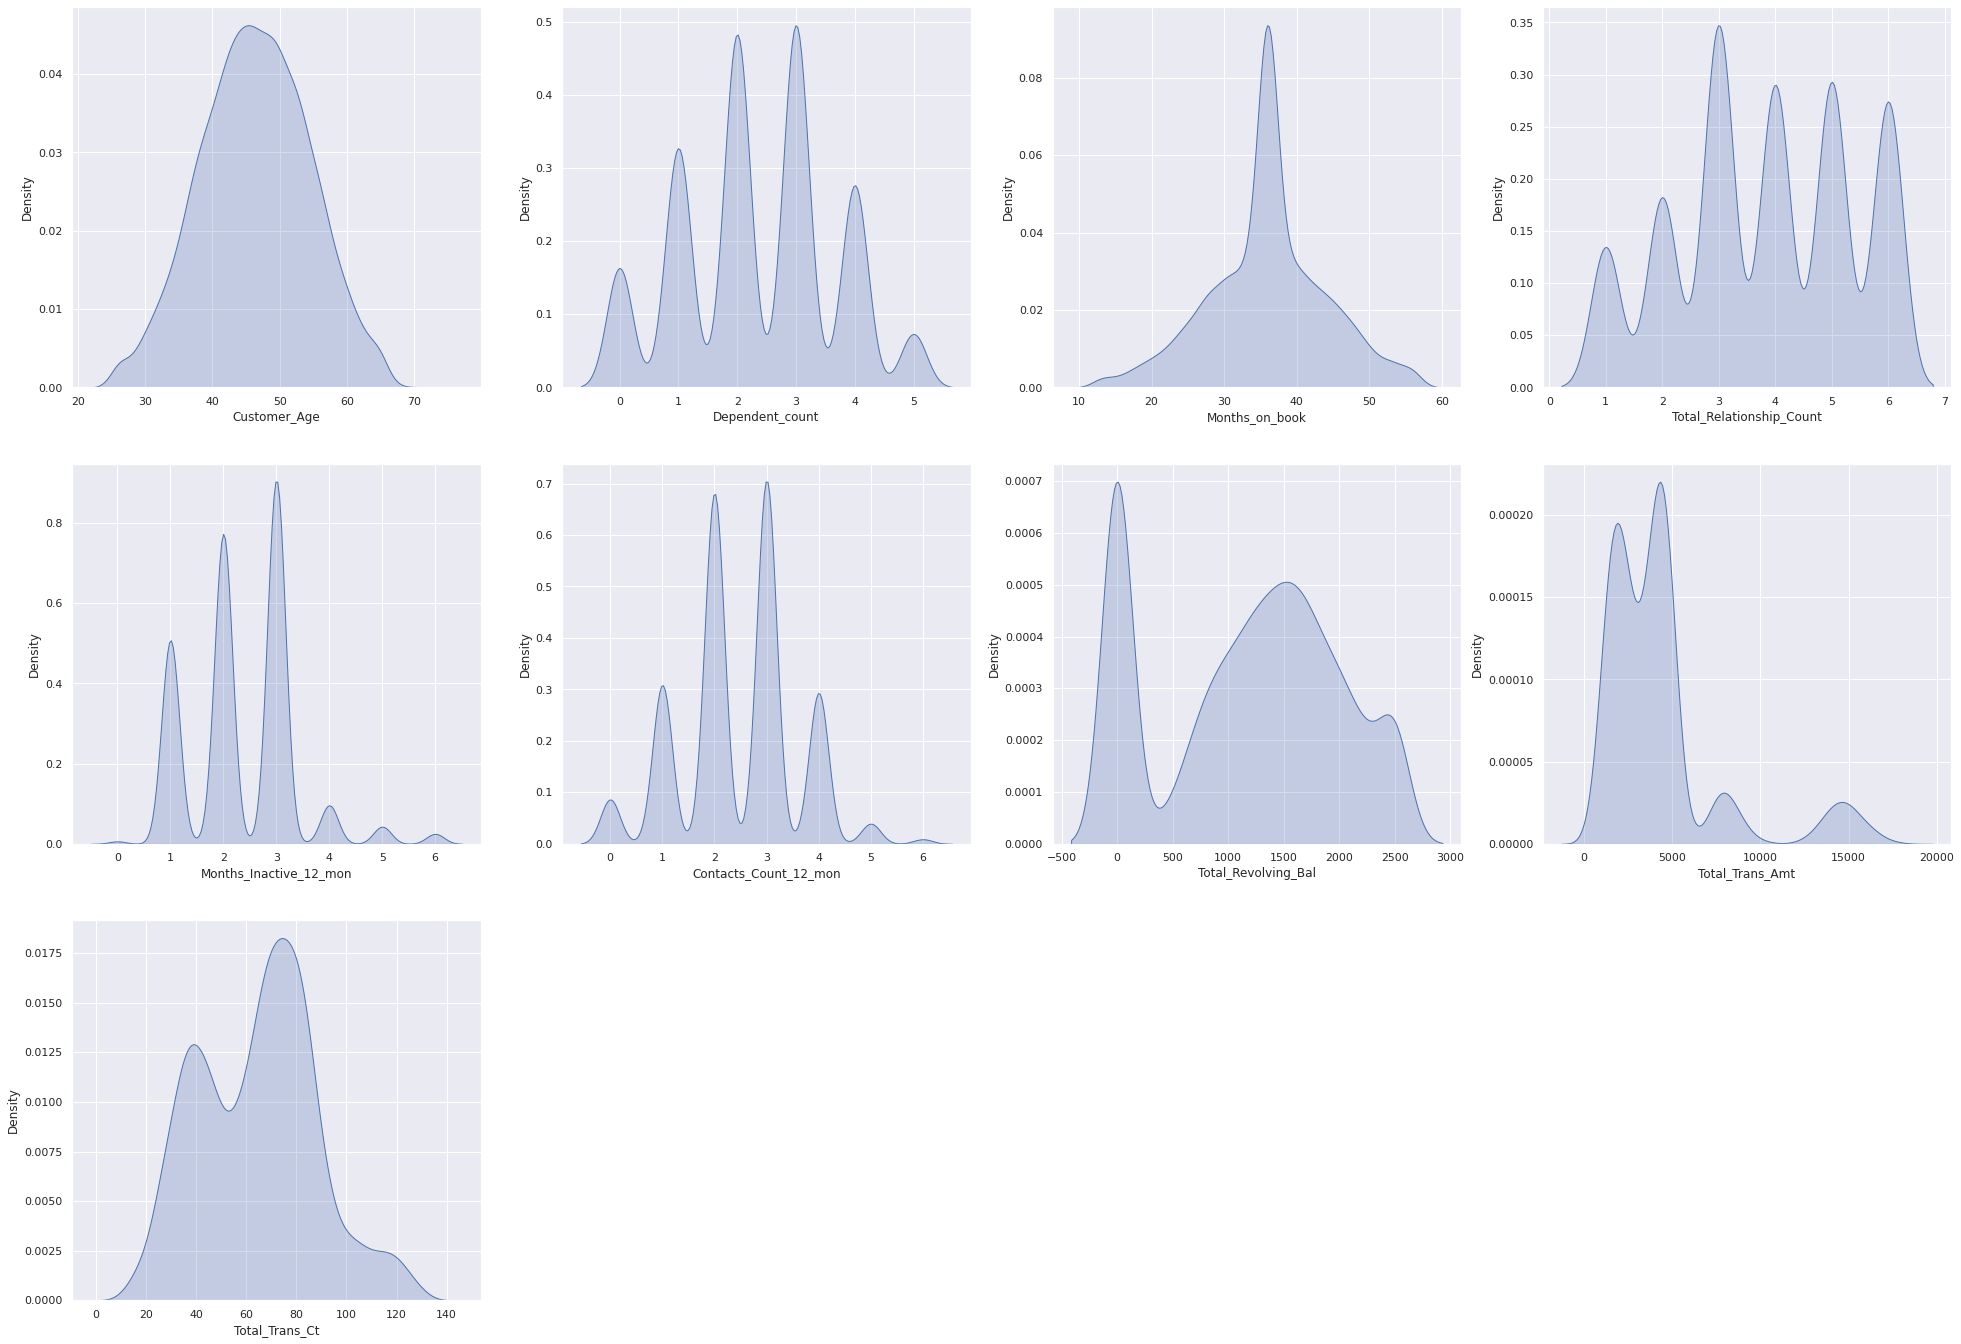

In [ ]:
sns.set(rc={'figure.figsize': (30, 30)})
for i in range(len(int_cols)):
    plt.subplot(4, 4, i + 1)
    sns.kdeplot(df[int_cols[i]], shade=True)

In [ ]:
df[cat_cols].describe()

,Attrition_Flag,Gender,Education_Level,Marital_Status,Income_Category,Card_Category
count,7081,7081,7081,7081,7081,7081
unique,2,2,6,3,5,4
top,Existing Customer,M,Graduate,Married,Less than $40K,Blue
freq,5968,3706,2591,3564,2792,6598


In [ ]:
def stacked_plot(x):
    sns.set(palette='Set1')
    tab1 = pd.crosstab(x, df['Attrition_Flag'],margins=True)
    print(tab1)
    print('-'*120)
    tab = pd.crosstab(x,df['Attrition_Flag'],normalize='index')
    tab.plot(kind='bar',stacked=True,figsize=(10,5))
    plt.legend(loc='lower left', frameon=True)
    plt.legend(loc="upper left", bbox_to_anchor=(1,1))
    plt.ylabel('Percentage')
    plt.show()

Attrition_Flag  Attrited Customer  Existing Customer   All
Gender                                                    
F                             576               2799  3375
M                             537               3169  3706
All                          1113               5968  7081
------------------------------------------------------------------------------------------------------------------------


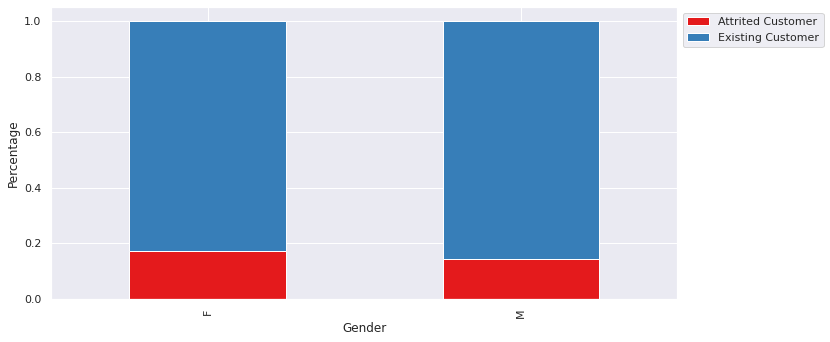

In [ ]:
stacked_plot(df['Gender'])

Attrition_Flag   Attrited Customer  Existing Customer   All
Dependent_count                                            
0                              101                535   636
1                              184               1090  1274
2                              285               1595  1880
3                              329               1600  1929
4                              171                906  1077
5                               43                242   285
All                           1113               5968  7081
------------------------------------------------------------------------------------------------------------------------


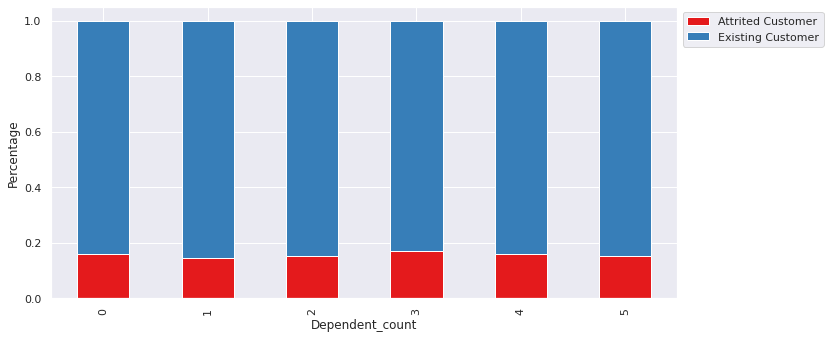

In [ ]:
stacked_plot(df["Dependent_count"])

Attrition_Flag   Attrited Customer  Existing Customer   All
Education_Level                                            
College                        132                712   844
Doctorate                       75                283   358
Graduate                       406               2185  2591
High School                    237               1416  1653
Post-Graduate                   77                354   431
Uneducated                     186               1018  1204
All                           1113               5968  7081
------------------------------------------------------------------------------------------------------------------------


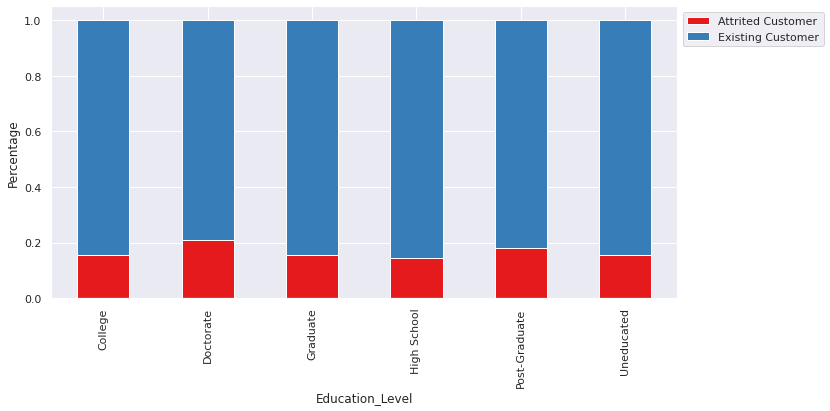

In [ ]:
stacked_plot(df['Education_Level'])

Attrition_Flag  Attrited Customer  Existing Customer   All
Marital_Status                                            
Divorced                       92                477   569
Married                       529               3035  3564
Single                        492               2456  2948
All                          1113               5968  7081
------------------------------------------------------------------------------------------------------------------------


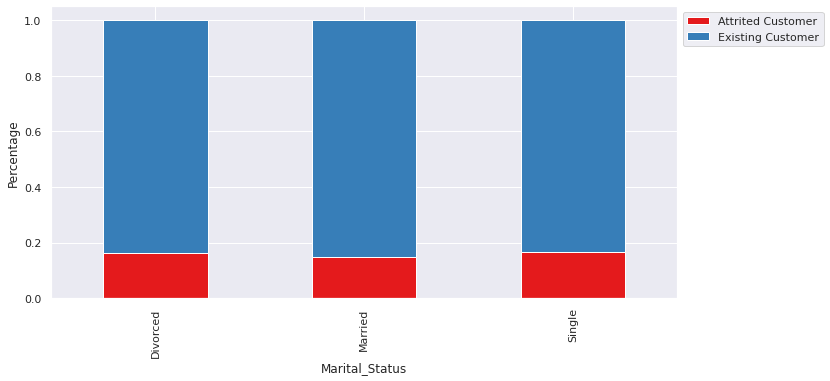

In [ ]:
stacked_plot(df['Marital_Status'])

Attrition_Flag   Attrited Customer  Existing Customer   All
Income_Category                                            
$120K +                        102                470   572
$40K - $60K                    204               1208  1412
$60K - $80K                    145                958  1103
$80K - $120K                   189               1013  1202
Less than $40K                 473               2319  2792
All                           1113               5968  7081
------------------------------------------------------------------------------------------------------------------------


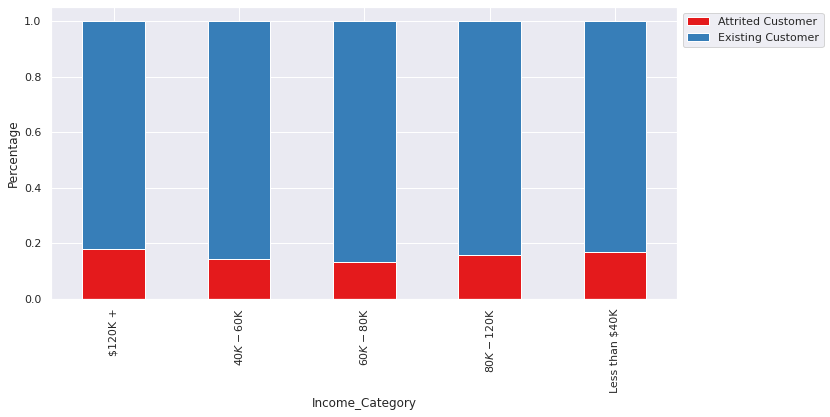

In [ ]:
stacked_plot(df['Income_Category'])

Attrition_Flag  Attrited Customer  Existing Customer   All
Card_Category                                             
Blue                         1034               5564  6598
Gold                           13                 68    81
Platinum                        3                  8    11
Silver                         63                328   391
All                          1113               5968  7081
------------------------------------------------------------------------------------------------------------------------


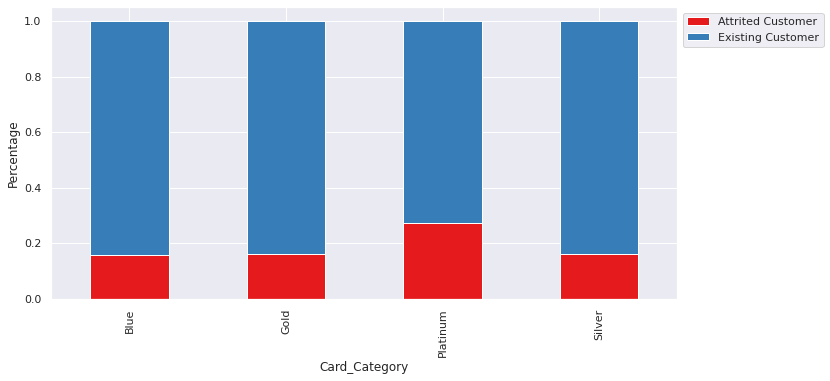

In [ ]:
stacked_plot(df['Card_Category'])

Cреди категориальных переменных процент Атрибутов клиентов кажется примерно одинаковым по всем категориям всех колонок. Несмотря на большой дисбаланс в пропорциях по категориям похоже, что не существует значимой категориальной переменной, которая показывала бы сильный индикатор значимости.

Матрица кореляции


Поскольку корреляция работает только с числовым типом, я буду кодировать все категориальные значения в категориальных функциях в числа с помощью pandas.factorize

In [ ]:
cat_df = df[cat_cols].apply(lambda x : pd.factorize(x)[0])
cat_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7081 entries, 0 to 10126
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype
---  ------           --------------  -----
 0   Attrition_Flag   7081 non-null   int64
 1   Gender           7081 non-null   int64
 2   Education_Level  7081 non-null   int64
 3   Marital_Status   7081 non-null   int64
 4   Income_Category  7081 non-null   int64
 5   Card_Category    7081 non-null   int64
dtypes: int64(6)
memory usage: 707.2 KB


In [ ]:
concat_df = pd.concat([cat_df, df[int_cols]], axis=1)
concat_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7081 entries, 0 to 10126
Data columns (total 15 columns):
 #   Column                    Non-Null Count  Dtype
---  ------                    --------------  -----
 0   Attrition_Flag            7081 non-null   int64
 1   Gender                    7081 non-null   int64
 2   Education_Level           7081 non-null   int64
 3   Marital_Status            7081 non-null   int64
 4   Income_Category           7081 non-null   int64
 5   Card_Category             7081 non-null   int64
 6   Customer_Age              7081 non-null   int64
 7   Dependent_count           7081 non-null   int64
 8   Months_on_book            7081 non-null   int64
 9   Total_Relationship_Count  7081 non-null   int64
 10  Months_Inactive_12_mon    7081 non-null   int64
 11  Contacts_Count_12_mon     7081 non-null   int64
 12  Total_Revolving_Bal       7081 non-null   int64
 13  Total_Trans_Amt           7081 non-null   int64
 14  Total_Trans_Ct            7081 non-null

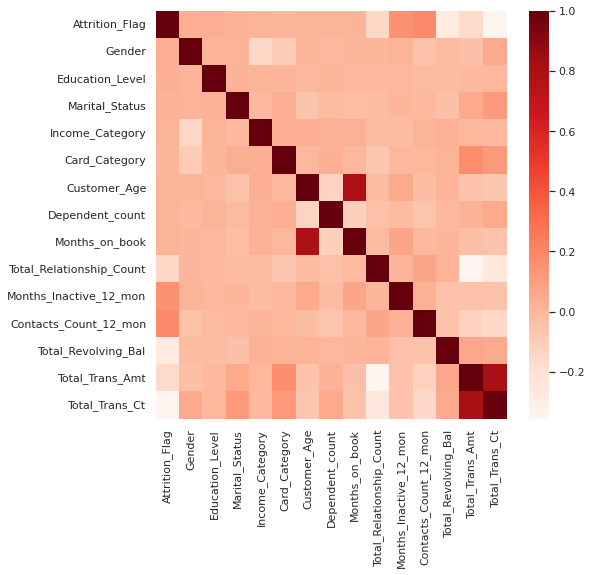

In [ ]:
fig = plt.subplots(figsize = (7,7))
sns.heatmap(concat_df.corr(), cmap='Reds')

In [ ]:
df.corr()[(df.corr() > 0.2) & (df.corr() != 1)]

,Customer_Age,Dependent_count,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio
Customer_Age,NaN,NaN,0.791271,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Dependent_count,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Months_on_book,0.791271,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Total_Relationship_Count,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Months_Inactive_12_mon,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Contacts_Count_12_mon,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Credit_Limit,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.996041,NaN,NaN,NaN,NaN,NaN
Total_Revolving_Bal,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.626391
Avg_Open_To_Buy,NaN,NaN,NaN,NaN,NaN,NaN,0.996041,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Total_Amt_Chng_Q4_Q1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.390099,NaN


Изучение Attrition_Age с другой переменной не показывает нам никакой корреляции.

Посмотрим на визуализацию других колонок друг с другом в разных вариациях

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


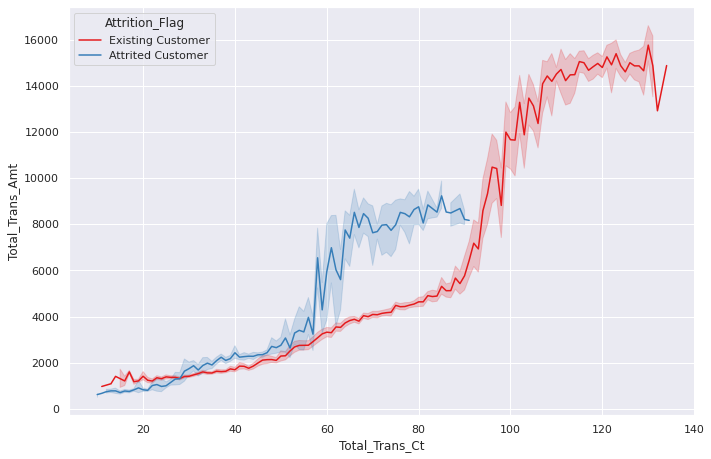

In [ ]:
#  Total_Trans_Ct && Total_Trans_Amt
plt.figure(figsize=(10,7))
sns.lineplot(df['Total_Trans_Ct'],df['Total_Trans_Amt'],hue=df['Attrition_Flag'])

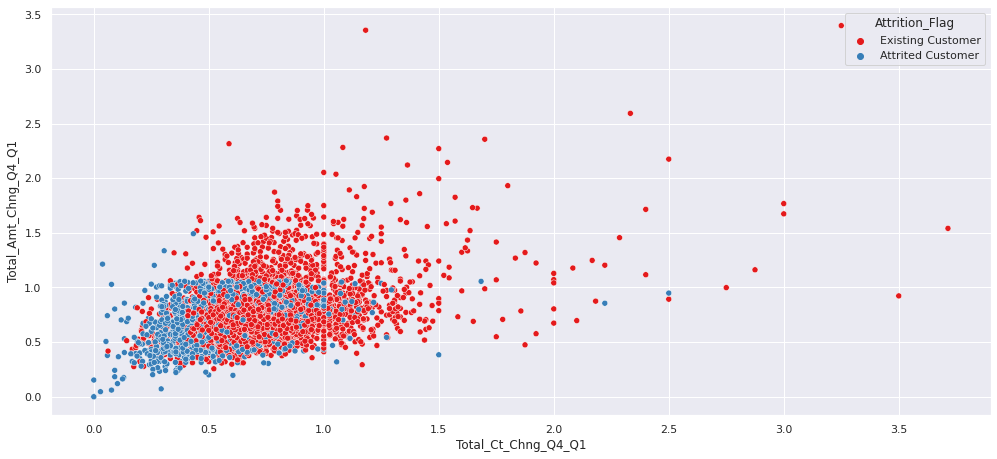

In [ ]:
plt.figure(figsize=(15,7))
sns.scatterplot(x='Total_Ct_Chng_Q4_Q1', y='Total_Amt_Chng_Q4_Q1',hue='Attrition_Flag',
             data=df)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<Figure size 1080x504 with 0 Axes>

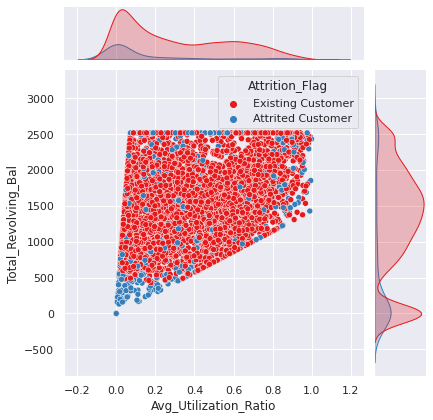

In [ ]:
plt.figure(figsize=(15,7))
sns.jointplot(df['Avg_Utilization_Ratio'],df['Total_Revolving_Bal'], hue = df['Attrition_Flag'])

Посмотрим на выбросы по типу boxplot

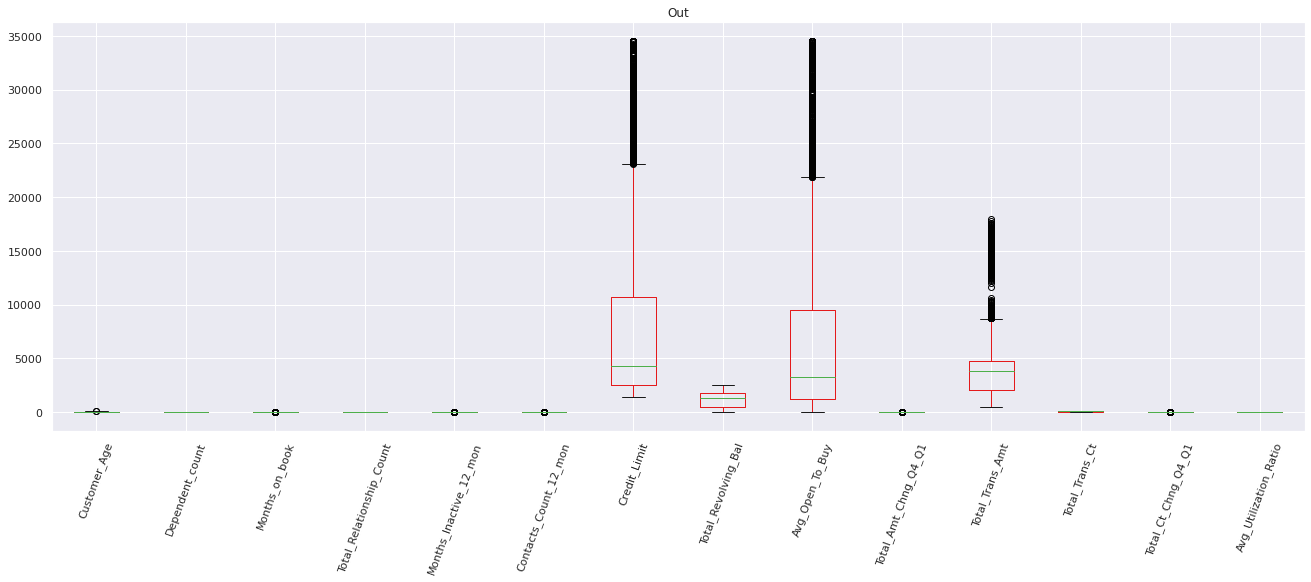

In [ ]:

outlier= df.plot(kind='box',figsize=(20,7));
plt.xticks(rotation=70);
plt.title('Out');

In [ ]:
# Заменим выбросы 
def emissions(col):
  q1 = df[col].quantile(q=0.25)
  q3 = df[col].quantile(q=0.75)
  k = 1.5
  iqr = q3-q1
  l = q1 - k * iqr
  u = q3 + k * iqr
  i = df[(df[col] < l)|(df[col] > u)][col].index
  df.loc[i, col] = df[col].mean()

col = ['Credit_Limit','Avg_Open_To_Buy','Total_Trans_Amt']
for c in col:
  emissions(c)

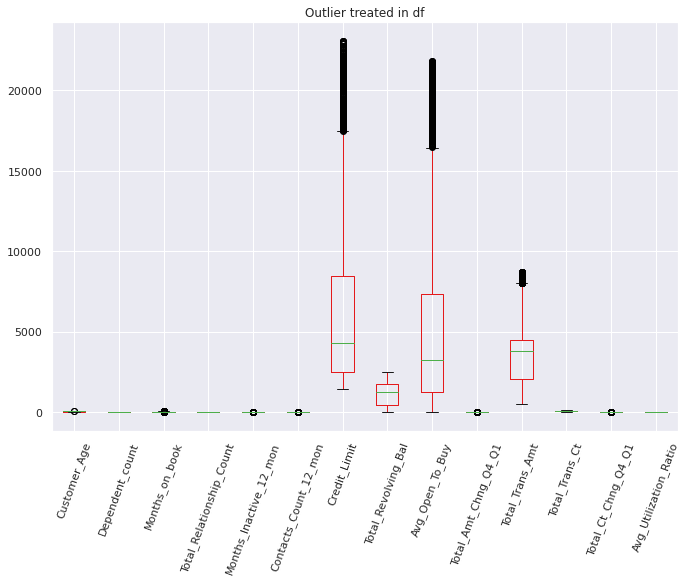

In [ ]:
outlier= df.plot(kind='box',figsize=(10,7));
plt.xticks(rotation=70);
plt.title('Outlier treated in df');

Приступим к обучению

In [ ]:
#  преобразуем категорильные колонки
for feature in df.columns:
    if df[feature].dtype =='object':
        df[feature] = pd.Categorical(df[feature]).codes

In [ ]:
X = df[['Gender', 'Dependent_count',
       'Education_Level', 'Marital_Status', 'Income_Category', 'Card_Category',
       'Months_on_book', 'Total_Relationship_Count', 'Months_Inactive_12_mon',
       'Contacts_Count_12_mon', 'Credit_Limit',
       'Avg_Open_To_Buy', 'Total_Amt_Chng_Q4_Q1', 'Total_Trans_Amt',
       'Total_Ct_Chng_Q4_Q1', 'Avg_Utilization_Ratio']]

y = df.pop('Attrition_Flag')

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.30,random_state=0)

SMOTE


методы over_sampling, используемые для настройки распределения классов набора данных

In [ ]:
OS_SMOTE = SMOTE()

X_train, train_labels = OS_SMOTE.fit_resample(X_train,y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


собираем результаты

In [ ]:
all_models = []

all_models.append(('ADA',make_pipeline
                   (AdaBoostClassifier(random_state=23)
                   )))
all_models.append(('GRB',make_pipeline
                   (GradientBoostingClassifier(random_state=23)
                   )))
all_models.append(('XGB',make_pipeline
                   (XGBClassifier(random_state=23,eval_metric='logloss')
                   )))

In [ ]:
for i,j in all_models:
    j.fit(X_train,y_train)
    scoring='recall'
    kfold=StratifiedKFold(n_splits=5,shuffle=True,random_state=23)
    cv_result=cross_val_score(estimator=j, X=X_train, y=y_train, scoring=scoring, cv=kfold) 
    print(f'{i}: {cv_result.mean()}')

ADA: 0.9368837081176693
GRB: 0.9669969408319197
XGB: 0.9677201223667231


Построение моделей ADA  с использованием RandomSearchCV

ансамблевый алгоритм обучения, который берет множество алгоритмов обучения, например, деревья решений, и объединяет их. Целью является взять набор или группу слабых классификаторов и объединить их в один сильный.

In [ ]:
# создаем пайплайн
pipe_ADA2 = make_pipeline(AdaBoostClassifier(random_state=23))

# задаем параметры
parameters = {
    "adaboostclassifier__base_estimator":[DecisionTreeClassifier(max_depth=1,
                                                                 random_state=23),
                                         DecisionTreeClassifier(max_depth=2,
                                                                random_state=23),
                                         DecisionTreeClassifier(max_depth=3,
                                                                random_state=23)],
    "adaboostclassifier__n_estimators": np.arange(10,60,5),
    "adaboostclassifier__learning_rate": [0.05,0.15,0.45,0.75]} 
                                                   

#scoring метрика
scoring = metrics.make_scorer(metrics.recall_score)

# GridSearch CV
RS_cv = RandomizedSearchCV(estimator=pipe_ADA2,scoring=scoring,
                           param_distributions=parameters,random_state=23,
                           n_iter=50,n_jobs=-1,cv=5)
RS_cv.fit(X_train,y_train)

print(RS_cv.best_params_)
print(RS_cv.best_score_)

{'adaboostclassifier__n_estimators': 50, 'adaboostclassifier__learning_rate': 0.15, 'adaboostclassifier__base_estimator': DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=3, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=23, splitter='best')}
0.9751807228915663


In [ ]:
# создаем новый пайплайн с лучшим параметром
ada_tuned2 = make_pipeline(AdaBoostClassifier
                         (base_estimator=DecisionTreeClassifier(max_depth=3,
                                                              random_state=23),
                         learning_rate=0.75,
                         n_estimators= 35,
                         random_state=23))
#обучаем модель
ada_tuned2.fit(X_train,y_train)

Pipeline(memory=None,
         steps=[('adaboostclassifier',
                 AdaBoostClassifier(algorithm='SAMME.R',
                                    base_estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                                          class_weight=None,
                                                                          criterion='gini',
                                                                          max_depth=3,
                                                                          max_features=None,
                                                                          max_leaf_nodes=None,
                                                                          min_impurity_decrease=0.0,
                                                                          min_impurity_split=None,
                                                                          min_samples_leaf=1,
                                       

In [ ]:
# функция для отрисовки conflusion matrix
def make_confusion_matrix(model,y_actual):
    sns.set(font_scale=2.0)
    y_predict = model.predict(X_test)
    cm=confusion_matrix(y_actual,y_predict)
    group_names = ['True -ve','False +ve','False -ve','True +ve']
    group_counts = ["{0:0.0f}".format(value) for value in
                cm.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in
                         cm.flatten()/np.sum(cm)]
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2,v3 in
              zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    plt.figure(figsize = (10,7))
    sns.heatmap(cm, annot=labels,fmt='',cmap='Blues')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [ ]:
# функция для результатов
def scores(model,train_x,train_y,flag=True):
    score_list=[] 
    y_pred_train = model.predict(train_x)
    y_pred_test = model.predict(X_test)
    train_acc = metrics.accuracy_score(train_y,y_pred_train)
    test_acc = metrics.accuracy_score(y_test,y_pred_test)
    train_recall = metrics.recall_score(train_y,y_pred_train)
    test_recall = metrics.recall_score(y_test,y_pred_test)
    train_precision = metrics.precision_score(train_y,y_pred_train)
    test_precision = metrics.precision_score(y_test,y_pred_test)
    score_list.extend((train_acc,test_acc,train_recall,test_recall,train_precision,test_precision))
    if flag== True:
        print("Accuracy on training set : ",metrics.accuracy_score(train_y,y_pred_train))
        print("Accuracy on test set : ",metrics.accuracy_score(y_test,y_pred_test))
        print("\nRecall on training set : ",metrics.recall_score(train_y,y_pred_train))
        print("Recall on test set : ",metrics.recall_score(y_test,y_pred_test))
        print("\nPrecision on training set : ",metrics.precision_score(train_y,y_pred_train))
        print("Precision on test set : ",metrics.precision_score(y_test,y_pred_test))
    
    elif flag == False:
        return score_list #return this when flag is False

Accuracy on training set :  0.9798224374495561
Accuracy on test set :  0.9421176470588235

Recall on training set :  0.9922910142134426
Recall on test set :  0.9642267473858007

Precision on training set :  0.9837592548363984
Precision on test set :  0.9679558011049724


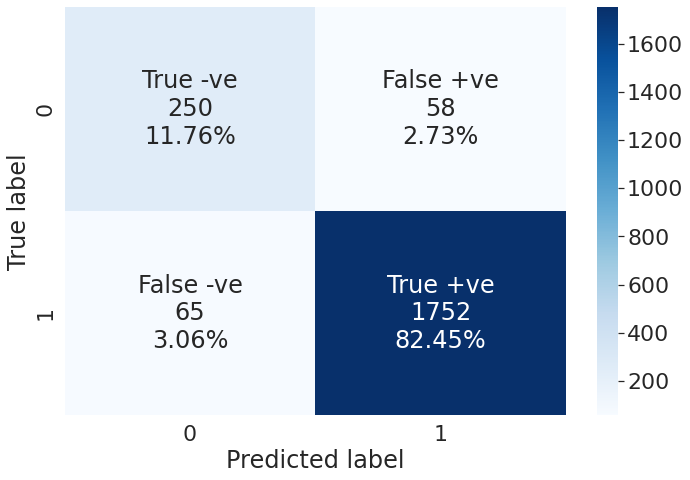

In [ ]:
scores(ada_tuned2,X_train,y_train)
make_confusion_matrix(ada_tuned2,y_test)

Неплохие результаты

GradientBoostingClassifier

алгоритм интеграции последовательностей, который объединяет ряд слабых классификаторов для повышения точности прогнозирования. Выход в любое время t является весом предыдущего выхода в момент времени t-1. Правильно классифицированные образцы получают меньший вес, а неправильно классифицированные образцы получают больший вес. Проблема регрессии использует похожую стратегию.

In [ ]:
#создаем пайплан
pipe_GRB2 = make_pipeline(GradientBoostingClassifier(random_state=23))
# параметры 
parameters = {
    "gradientboostingclassifier__n_estimators": np.arange(20,100,20),
    "gradientboostingclassifier__max_features":[0.6,0.7,0.8,0.9],
    'gradientboostingclassifier__learning_rate': [0.01,0.05,0.35,0.5],
    'gradientboostingclassifier__subsample':[0.6,0.7,0.8,0.9]
    }

#scoring метрика
scoring = metrics.make_scorer(metrics.recall_score)

RS_cv = RandomizedSearchCV(estimator=pipe_GRB2,
                           scoring=scoring,
                           param_distributions=parameters,
                           random_state=23,n_iter=50,n_jobs=-1,cv=5)
RS_cv.fit(X_train,y_train)

print(RS_cv.best_params_)
print(RS_cv.best_score_)

{'gradientboostingclassifier__subsample': 0.9, 'gradientboostingclassifier__n_estimators': 20, 'gradientboostingclassifier__max_features': 0.9, 'gradientboostingclassifier__learning_rate': 0.01}
1.0


In [ ]:
grb_tuned2 = make_pipeline(GradientBoostingClassifier
                          (learning_rate=0.35,
                           max_features=0.6,
                           n_estimators=80,random_state=23,
                          subsample = 0.7))
                                                                                      
#обучаем модель
grb_tuned2.fit(X_train,y_train)

Pipeline(memory=None,
         steps=[('gradientboostingclassifier',
                 GradientBoostingClassifier(ccp_alpha=0.0,
                                            criterion='friedman_mse', init=None,
                                            learning_rate=0.35, loss='deviance',
                                            max_depth=3, max_features=0.6,
                                            max_leaf_nodes=None,
                                            min_impurity_decrease=0.0,
                                            min_impurity_split=None,
                                            min_samples_leaf=1,
                                            min_samples_split=2,
                                            min_weight_fraction_leaf=0.0,
                                            n_estimators=80,
                                            n_iter_no_change=None,
                                            presort='deprecated',
                                 

Посмотрим результаты

Accuracy on training set :  0.9786117836965295
Accuracy on test set :  0.9501176470588235

Recall on training set :  0.993977354854252
Recall on test set :  0.9774353329664281

Precision on training set :  0.9807463750891372
Precision on test set :  0.9646931015752308


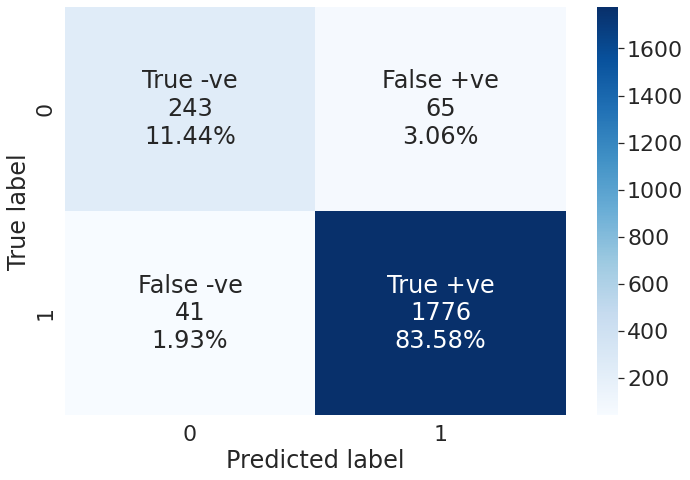

In [ ]:
scores(grb_tuned2,X_train,y_train)
make_confusion_matrix(grb_tuned2,y_test)

Прекрасные результаты!

XGBoostclassifier


строит модель предсказания в форме ансамбля слабых предсказывающих моделей, обычно деревьев решений. Обучение ансамбля проводится последовательно. На каждой итерации вычисляются отклонения предсказаний уже обученного ансамбля на обучающей выборке.

In [ ]:
pipe_XBG2 = make_pipeline(
                   (XGBClassifier
                    (random_state=23,eval_metric='logloss')
                   ))

parameters = {
    "xgbclassifier__n_estimators": np.arange(30,100,20),
     "xgbclassifier__subsample":[0.6,0.7,0.8],
    "xgbclassifier__learning_rate":[0.05,0.15,0.2,0.3],
    "xgbclassifier__gamma":[0,1,2,3],
    }

scoring = metrics.make_scorer(metrics.recall_score)

#RandomizedSearch CV
RS_cv = RandomizedSearchCV(estimator=pipe_XBG2,
                           scoring=scoring,
                           param_distributions=parameters,
                           random_state=23,n_iter=50,n_jobs=-1,cv=5)
RS_cv.fit(X_train,y_train)

print(RS_cv.best_params_)
print(RS_cv.best_score_)

{'xgbclassifier__subsample': 0.6, 'xgbclassifier__n_estimators': 70, 'xgbclassifier__learning_rate': 0.05, 'xgbclassifier__gamma': 2}
0.9886778884491033


In [ ]:
# новый пайплан с лучшими параметрами
xgb_tuned2 = make_pipeline(
                   (XGBClassifier
                    (random_state=23,
                     eval_metric='logloss',
                    learning_rate = 0.2,
                    n_estimators =90,
                    subsample = 0.7,
                    gamma = 3
                    )))
#fitting model on train data
xgb_tuned2.fit(X_train,y_train)

Pipeline(memory=None,
         steps=[('xgbclassifier',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, eval_metric='logloss',
                               gamma=3, learning_rate=0.2, max_delta_step=0,
                               max_depth=3, min_child_weight=1, missing=None,
                               n_estimators=90, n_jobs=1, nthread=None,
                               objective='binary:logistic', random_state=23,
                               reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
                               seed=None, silent=None, subsample=0.7,
                               verbosity=1))],
         verbose=False)

Результаты и матрица

Accuracy on training set :  0.968321226795803
Accuracy on test set :  0.952

Recall on training set :  0.991086485184293
Recall on test set :  0.9818381948266374

Precision on training set :  0.9716580066131318
Precision on test set :  0.9627630868861305


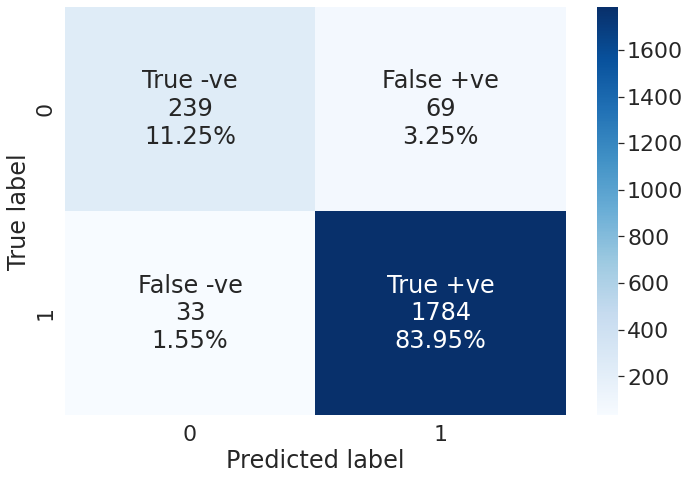

In [ ]:
scores(xgb_tuned2,X_train,y_train)
make_confusion_matrix(xgb_tuned2,y_test)

Результаты поражают 

Сравним модели

In [ ]:
models = [ada_tuned2,
          grb_tuned2,
          xgb_tuned2]
# для добавления результатов обучения и тестирования
acc_train = []
acc_test = []
recall_train = [] 
recall_test = []
precision_train = [] 
precision_test = []

# перебрать все модели, чтобы получить оценку метрик
for model in models:
    j = scores(model,X_train,y_train,False)
    acc_train.append(j[0])
    acc_test.append(j[1])
    recall_train.append(j[2])
    recall_test.append(j[3])
    precision_train.append(j[4])
    precision_test.append(j[5])


comparison_frame = pd.DataFrame({'Model':['ADA_Boost-RandomizedSearchCV',
                                          'Gradient_Boost-RandomizedSearchCV',
                                          'XG_Boost-RandomizedSearchCV'],
                                 'Train_Accuracy': acc_train,'Test_Accuracy': acc_test,
                                          'Train_Recall':recall_train, 'Test_Recall':recall_test,
                                           'Train_Precision':precision_train, 'Test_Precision':precision_test}) 

#Отсортируем
comparison_frame.sort_values(by='Test_Recall',ascending=False).reset_index()

,index,Model,Train_Accuracy,Test_Accuracy,Train_Recall,Test_Recall,Train_Precision,Test_Precision
0,2,XG_Boost-RandomizedSearchCV,0.968321,0.952000,0.991086,0.981838,0.971658,0.962763
1,1,Gradient_Boost-RandomizedSearchCV,0.978612,0.950118,0.993977,0.977435,0.980746,0.964693
2,0,ADA_Boost-RandomizedSearchCV,0.979822,0.942118,0.992291,0.964227,0.983759,0.967956


Все модели показали хороший результат на самоме деле

Таким образом, ADA имеет лучший отзыв и является лучшей моделью для этого набора данных.